In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
from argparse import Namespace
from ast import literal_eval
import copy
import gzip
import itertools
import json
import math
import os
import pickle
import sys
import textwrap
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import duckdb
from IPython.display import display, Markdown, HTML  # type: ignore
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from Levenshtein import distance as _edit_distance
import numpy as np
import pandas as pd
import tabulate
import tatsu
import tatsu.ast
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tabulate
from tqdm.notebook import tqdm
from scipy import stats
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src.ast_utils import _extract_game_id, deepcopy_ast, replace_child
from src.ast_printer import ast_to_lines
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.fitness_features import *
from src.ast_counter_sampler import *
from src.evolutionary_sampler import *
from src import fitness_features_by_category, latest_model_paths

2024-05-23 13:14:53 - ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache
2024-05-23 13:14:53 - src.ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache


In [3]:

grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
# regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
# print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)

fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
fitness_df.head()

2024-05-23 13:14:57 - ast_utils - INFO     - Loading from cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz
2024-05-23 13:14:57 - ast_utils - INFO     - Finished loading cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz


['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_prop,variables_used_all,variables_used_prop,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1.0,1,1.0,...,0.969177,0.979573,0.965285,0.976289,0.977376,0.980148,0.915272,0.960175,0.999188,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1.0,1,1.0,...,0.974875,0.978991,0.961082,0.972691,0.971810,0.980943,0.895362,0.910697,0.963311,0.973001
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1.0,1,1.0,...,0.954233,0.972808,0.000000,0.000000,0.000000,0.000000,0.841097,0.898279,0.946597,0.955042
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1.0,1,1.0,...,0.986178,0.982877,0.000000,0.000000,0.000000,0.000000,0.915272,0.960175,0.999188,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1.0,1,1.0,...,0.984002,0.979782,0.000000,0.000000,0.000000,0.000000,0.964905,0.971973,0.972563,0.962818


In [4]:
SUBPLOTS_ADJUST_PARAMS = dict(top=0.925)
DEFAULT_IGNORE_METRICS = ['Timestamp']


FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = './figures'


def save_plot(save_path, bbox_inches='tight', should_print=False):
    if save_path is not None:
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX):
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        save_path = os.path.abspath(save_path)
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')


In [5]:
NEW_REPRESENTATIVE_INDICES = [
    42,  # throw
    58,  # funny throw with setup
    28,  # throw, throw attempt, with setup 
    88,  # throw, throw attempt, no setup
    31,  # throw without in/on
    64,  # dropping ball in bin, drop attempt
    52,  # ball-less throwing game
    86,  # weird throw, with setup
    6,  # two weird throwing preferences, setup
    17,  # anoter weird multi throwing preference game
    96,  # three throwing preferences, setup
    
    14,  # castle building
    45,  # weird building game
    49,  # another weird building game
    51,  # hybrid throwing/building game
    
    23,  # single placement preference
    44,  # three different placement preferencs 

    26,  # single preferece that matches none of the others
]

REAL_GAME_INDICES_TO_IGNORE = [
    2,  # used in the context for backtranslation
    5,  # used in the context for backtranslation
    18, # used in the context for backtranslation
    33, # used in the context for backtranslation
    44, # used in the context for backtranslation
]

REAL_GAME_INDICES_TO_INCLUDE = [
    0, 4, 6, 7, 11,
    14, 17, 23, 26, 28,
    31, 32, 35, 37, 40,
    41, 42, 45, 49, 51,
    52, 55, 58, 59, 64,
    74, 88, 90, 94, 96,
]


In [6]:
# trace_filter_results_path = '../samples/trace_filter_results_max_exemplar_preferences_by_bcs_with_expected_values_2023_11_29_2023_12_05_1.pkl.gz'
model_key = 'max_exemplar_preferences_by_bcs_with_expected_values'
model_spec = latest_model_paths.MAP_ELITES_MODELS[model_key]
model = typing.cast(MAPElitesSampler, model_spec.load())

key_to_real_game_index = defaultdict(list)
real_game_index_to_key = {}
real_game_fitness_scores = []
ALL_REAL_GAME_KEYS = []
for i, ast in enumerate(game_asts):
    fitness_score, features = model._score_proposal(ast, return_features=True)  # type: ignore
    real_game_fitness_scores.append(fitness_score)
    key = model._features_to_key(ast, features)
    key_to_real_game_index[key].append(i)
    real_game_index_to_key[i] = key
    ALL_REAL_GAME_KEYS.append(key)

trace_filter_results = model_spec.load_trace_filter_data()
trace_filter_results.keys()

2024-05-23 13:14:59 - compile_predicate_statistics_full_database - INFO     - Loading data from files with query timeout 15
2024-05-23 13:15:22 - compile_predicate_statistics_full_database - INFO     - Creating DuckDB table...
2024-05-23 13:15:23 - compile_predicate_statistics_full_database - INFO     - Creating data table indices...
2024-05-23 13:15:43 - compile_predicate_statistics_full_database - INFO     - Loaded data, found 843825 rows


dict_keys(['summary', 'full'])

In [7]:
real_game_index_to_key[5]

for key, indices in key_to_real_game_index.items():
    if key is None or not isinstance(key, tuple):
        continue
    if key[2] == real_game_index_to_key[5][2] and key[3] >= 1 and key[1] == real_game_index_to_key[5][1]:
        print(key, indices)

(1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0) [1, 28, 34, 63, 95]
(1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0) [5]
(1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0) [12]
(1, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 0) [37]


## Figure out which human games to include
* For each cell where there are  > 0 human games, check if there's one in the representative index list that isn't in the ignore list
* If so, add it to the list of human games to include
* If not, print the list of candidate human games to include

In [8]:
# for key, indices in key_to_real_game_index.items():
#     if key != None:
#         relevant_indices = [i for i in indices if i not in REAL_GAME_INDICES_TO_IGNORE]
#         if len(relevant_indices) == 0:
#             print('*', key, '∅')
#             continue

#         representative_indices = [i for i in relevant_indices if i in NEW_REPRESENTATIVE_INDICES]
#         if len(representative_indices) > 0:
#             print('*', key, representative_indices, '(r)')

#         else:
#             print('*', key, relevant_indices)

REAL_GAME_KEY_LIST = [real_game_index_to_key[i] for i in REAL_GAME_INDICES_TO_INCLUDE]
REAL_GAME_KEYS = set(REAL_GAME_KEY_LIST)
print(len(REAL_GAME_KEYS))

30


In [193]:
key_to_real_game_index[(1, 0, 4, 0, 0, 2, 0, 0, 0, 0, 1, 0)]

[17]

In [194]:
index = 17
key = real_game_index_to_key[index]
print(index, key)
print('\n' + '=' * 100 + '\n')
print(ast_printer.ast_to_string(game_asts[index], '\n'))
print('\n' + '=' * 100 + '\n')
print(ast_printer.ast_to_string(model.population[key], '\n'))

17 (1, 0, 4, 0, 0, 2, 0, 0, 0, 0, 1, 0)


(define (game 5c79bc94d454af00160e2eee-21) (:domain few-objects-room-v1)
(:setup
  (exists (?c - chair)
    (game-conserved
      (and
        (near room_center ?c)
        (not
          (faces ?c desk)
       )
        (not
          (faces ?c bed)
       )
     )
   )
 )
)
(:constraints
  (and
    (preference ballThrownToBin
      (exists (?d - dodgeball ?h - hexagonal_bin)
        (then
          (once (and (agent_holds ?d) (adjacent desk agent)))
          (hold (and (not (agent_holds ?d)) (in_motion ?d)))
          (once (and (not (in_motion ?d)) (in ?h ?d)))
       )
     )
   )
    (preference ballThrownToBed
      (exists (?d - dodgeball)
        (then
          (once (and (agent_holds ?d) (adjacent desk agent)))
          (hold (and (not (agent_holds ?d)) (in_motion ?d)))
          (once (and (not (in_motion ?d)) (on bed ?d)))
       )
     )
   )
    (preference ballThrownToChair
      (exists (?d - dodgeball ?c - chair)
        (the

In [83]:
key = real_game_index_to_key[83]
print(key, '\n')
print(ast_printer.ast_to_string(model.population[key], '\n'))

(1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0) 

(define (game evo-8126-12-0) (:domain many-objects-room-v1)
(:setup
  (exists (?v0 - hexagonal_bin)
    (game-conserved
      (near rug ?v0)
   )
 )
)
(:constraints
  (and
    (preference preference0
      (exists (?v1 - hexagonal_bin ?v0 - dodgeball)
        (then
          (once (agent_holds ?v0))
          (hold (and (not (agent_holds ?v0)) (in_motion ?v0)))
          (once (and (not (in_motion ?v0)) (in ?v1 ?v0) (on ?v1 ?v0)))
       )
     )
   )
 )
)
(:scoring
  (count preference0)
)
)


## Figure out which model games to include
* We're taking the 30 from the keys used in the human games
* We want $n = 40$ additional ones:
    * All 40 with the behavioral feature expected values key set to 1
    * 10 with each preference count
    * 20 with/without setup
    * With each of the 9 preference BCs on 20 times and off 20 times


In [19]:
BINARY_FEATURE_INDICES = list(range(3, 12))


def sample_novel_map_elites_keys(n: int, model: MAPElitesSampler, trace_filter_results: dict,
                                 real_game_keys: typing.Set[KeyTypeAnnotation] = REAL_GAME_KEYS,
                                 random_seed: int = DEFAULT_RANDOM_SEED, max_pref_count: int = 4,
                                 binary_feature_indices: typing.List[int] = BINARY_FEATURE_INDICES,
                                 pref_count_feature_index: int = 2,
                                 ) -> typing.List[KeyTypeAnnotation]:
    rng = np.random.default_rng(random_seed)
    sampled_keys = []
    candidate_keys = set([key for key in model.population.keys() if key[0] == 1]) - real_game_keys  # type: ignore
    trace_filter_failed_keys = set([key for key, result in trace_filter_results['summary'].items() if result == 0])
    candidate_keys.difference_update(trace_filter_failed_keys)
    valid_pref_counts = list(range(1, max_pref_count + 1))
    
    pref_count_max_count = n // len(valid_pref_counts) 
    extra_for_next_pref_count = 0

    for pref_count in valid_pref_counts:
        sampled_keys_current_pref_count = []
        candidate_keys_current_pref_count = set([key for key in candidate_keys if key[pref_count_feature_index] == pref_count])  # type: ignore
        
        if len(candidate_keys_current_pref_count) < pref_count_max_count:
            extra_for_next_pref_count += pref_count_max_count - len(candidate_keys_current_pref_count)
            sampled_keys_current_pref_count.extend(list(candidate_keys_current_pref_count))
            candidate_keys_current_pref_count.clear()
        
        else:
            count_by_binary_value = {idx: 0 for idx in binary_feature_indices}

            while len(sampled_keys_current_pref_count) < pref_count_max_count + extra_for_next_pref_count:
                min_value = min(count_by_binary_value.values())
                binary_indices_above_min_value = [idx for idx in binary_feature_indices if count_by_binary_value[idx] > min_value]
                relevant_keys = [key for key in candidate_keys_current_pref_count if all(key[idx] == 0 for idx in binary_indices_above_min_value)]  # type: ignore
                if len(relevant_keys) == 0:
                    # Ran out of keys with current min, so increment everywhere to current min
                    count_by_binary_value = {idx: min_value for idx in binary_feature_indices}
                    continue

                key_index = rng.integers(len(relevant_keys))
                key = relevant_keys[key_index]
                sampled_keys_current_pref_count.append(key)
                candidate_keys_current_pref_count.discard(key)
                for i in binary_feature_indices:
                    count_by_binary_value[i] += key[i] > 0

            sampled_keys.extend(sampled_keys_current_pref_count)
            extra_for_next_pref_count = 0
            
    return sampled_keys


novel_archive_cell_keys = sample_novel_map_elites_keys(40, model, trace_filter_results)

In [ ]:
with open('./games_for_human_experiment/human_games.pddl', 'w') as f:
    for index in REAL_GAME_INDICES_TO_INCLUDE:
        f.write(f'; Index #{index} with key {real_game_index_to_key[index]} \n')
        f.write(ast_printer.ast_to_string(game_asts[index], '\n'))
        f.write('\n\n')


with open('./games_for_human_experiment/human_cell_archive_games.pddl', 'w') as f:
    for key in REAL_GAME_KEYS:
        f.write(f'; Key {key}\n')
        f.write(ast_printer.ast_to_string(model.population[key], '\n'))
        f.write('\n\n')


with open('./games_for_human_experiment/novel_archive_cell_games.pddl', 'w') as f:
    for key in novel_archive_cell_keys:
        f.write(f'; Key {key}\n')
        f.write(ast_printer.ast_to_string(model.population[key], '\n'))
        f.write('\n\n')

## Fixing the JSON structures because I messed the keys up

In [ ]:
with open('./games_for_human_experiment/human_cell_archive_games_translations.json') as f:
    human_cell_archive_games_translations = json.load(f)

modified_human_cell_archive_games_translations = {
    str(tuple(game['key'])): game['text'] for game in human_cell_archive_games_translations
}

with open('./games_for_human_experiment/modified_human_cell_archive_games_translations.json', 'w') as f:
    json.dump(modified_human_cell_archive_games_translations, f, indent=2)

with open('./games_for_human_experiment/human_games_translations.json') as f:
    human_games = json.load(f)

human_game_texts = [game['text'] for game in human_games]
modified_human_game_translations = {
    str(real_game_index_to_key[real_game_index]): human_game_texts[i]
    for i, real_game_index in enumerate(REAL_GAME_INDICES_TO_INCLUDE)
}

with open('./games_for_human_experiment/modified_human_games_translations.json', 'w') as f:
    json.dump(modified_human_game_translations, f, indent=2)

with open('./games_for_human_experiment/novel_archive_cell_games_translations.json') as f:
    novel_archive_cell_games_translations = json.load(f)

modified_novel_archive_cell_games_translations = {
    str(tuple(game['key'])): game['text'] for game in novel_archive_cell_games_translations
}

with open('./games_for_human_experiment/modified_novel_archive_cell_games_translations.json', 'w') as f:
    json.dump(modified_novel_archive_cell_games_translations, f, indent=2)

## Using these to make tables for the paper

In [12]:
TRANSLATIONS_DIR = '../llm_tests/translations'
TRANSLATION_DATE = '2024_01_12'

with open(f'{TRANSLATIONS_DIR}/human_games_translations_split_{TRANSLATION_DATE}.json') as f:
    human_game_texts = json.load(f)

with open(f'{TRANSLATIONS_DIR}/human_cell_archive_games_translations_split_{TRANSLATION_DATE}.json') as f:
    human_cell_archive_game_texts = json.load(f)

with open(f'{TRANSLATIONS_DIR}/novel_archive_cell_games_translations_split_{TRANSLATION_DATE}.json') as f:
    novel_archive_cell_game_texts = json.load(f)

## Analyzing fitness by group

real (μ = 36.52) vs matched (μ = 37.01)
    t-statistic = -3.075, p-value = 0.0032 **

real (μ = 36.52) vs unmatched (μ = 36.26)
    t-statistic = 1.485, p-value = 0.1421 

real (μ = 36.52) vs unmatched_top_30 (μ = 36.60)
    t-statistic = -0.513, p-value = 0.6098 

matched (μ = 37.01) vs unmatched (μ = 36.26)
    t-statistic = 4.640, p-value = 0.0000 ***

matched (μ = 37.01) vs unmatched_top_30 (μ = 36.60)
    t-statistic = 3.078, p-value = 0.0032 **

unmatched (μ = 36.26) vs unmatched_top_30 (μ = 36.60)
    t-statistic = -2.146, p-value = 0.0354 *



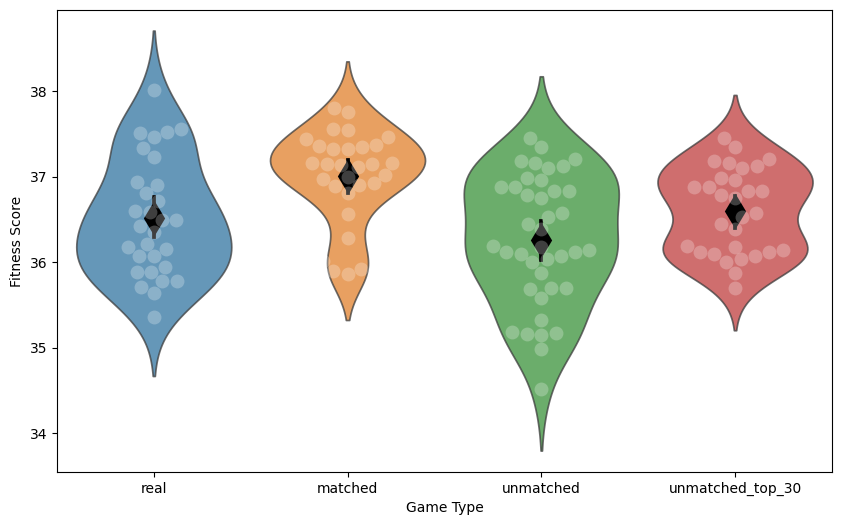

In [162]:
selected_real_game_fitness_scores = [real_game_fitness_scores[i] for i in REAL_GAME_INDICES_TO_INCLUDE]
matched_game_fitness_scores = [model.fitness_values[literal_eval(key)] for key in human_cell_archive_game_texts.keys()]
unmatched_game_fitness_scores = [model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()]
unmatched_game_fitness_scores_without_bottom_10 = list(sorted(unmatched_game_fitness_scores))[10:]

fitness_scores_by_type = dict(real=selected_real_game_fitness_scores, matched=matched_game_fitness_scores, unmatched=unmatched_game_fitness_scores, unmatched_top_30=unmatched_game_fitness_scores_without_bottom_10)

tab = '    '
for first, second in itertools.combinations(fitness_scores_by_type.keys(), 2):
    first_data = fitness_scores_by_type[first]
    second_data = fitness_scores_by_type[second]
    result = stats.ttest_ind(first_data, second_data)
    stars = '*' * int(result.pvalue < 0.05) + '*' * int(result.pvalue < 0.01) + '*' * int(result.pvalue < 0.001)
    print(f'{first} (\u03bc = {np.mean(first_data):.2f}) vs {second} (\u03bc = {np.mean(second_data):.2f})')
    p = result.pvalue
    p_value_str = f'p-value < 1e-7 {stars}' if p < 1e-7 else (f'p-value < 1e-5 {stars}' if p < 1e-5 else f'p-value = {p:.4f} {stars}')
    print(f'{tab}t-statistic = {result.statistic:.3f}, {p_value_str}')
    print()
    # print(f'{tab}p-value    = {result.pvalue:.3e} {stars}')


plt.figure(figsize=(10, 6))

sns.violinplot(data=fitness_scores_by_type, palette='tab10', inner=None, alpha=0.75)
sns.swarmplot(data=fitness_scores_by_type, color='white', dodge=False, size=10, alpha=0.25)
sns.pointplot(data=fitness_scores_by_type, errorbar=('ci', 95), linestyle='none', color='black', markers='d', markersize=15)

plt.xlabel('Game Type')
plt.ylabel('Fitness Score')
plt.show()

In [163]:
def tuple_distance(t1, t2):
    return sum(abs(x - y) for x, y in zip(t1, t2))


def min_tuple_distance(t, reference_ts):
    return min(tuple_distance(t, ref_t) for ref_t in reference_ts)


real_game_keys_to_scores = {REAL_GAME_KEY_LIST[i]: real_game_fitness_scores[idx] for i, idx in enumerate(REAL_GAME_INDICES_TO_INCLUDE)}
matched_game_key_to_scores = {key: model.fitness_values[literal_eval(key)] for key in human_cell_archive_game_texts.keys()}
unmatched_game_key_to_scores = {key: model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()}
unmatched_game_key_to_scores_without_bottom_10 = {key: model.fitness_values[literal_eval(key)] for key in novel_archive_cell_game_texts.keys()}
unmatched_game_key_to_scores_without_bottom_10 = {k: v for k, v in unmatched_game_key_to_scores_without_bottom_10.items() if v in unmatched_game_fitness_scores_without_bottom_10}


keys_to_fitness_scores = dict(
    real=real_game_keys_to_scores, 
    matched=matched_game_key_to_scores, 
    unmatched=unmatched_game_key_to_scores, 
    unmatched_top_30=unmatched_game_key_to_scores_without_bottom_10
)

df_rows = [
    {'full_game_id': f'{key}-{game_category}', 'fitness': score,  'archive_distance': min_tuple_distance(literal_eval(key) if isinstance(key, str) else key, REAL_GAME_KEY_LIST)}
    for game_category, key_to_scores in keys_to_fitness_scores.items()
    for key, score in key_to_scores.items()
]

df = pd.DataFrame(df_rows)
df.to_csv('./human_evals_data/full_game_id_to_fitness.csv', index=False)
df.tail()


,full_game_id,fitness,archive_distance
125,"(1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)-unmatched...",36.031338,6
126,"(1, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 1)-unmatched...",36.117832,4
127,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)-unmatched...",36.531780,4
128,"(1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched...",36.754009,2
129,"(1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0)-unmatched...",36.829990,2


## Actual tables now

In [ ]:
LSTLISTING_BEGIN = r'\begin{lstlisting}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]'
LSTLISTING_END = r'\end{lstlisting}'
SECTION_HEADERS = ['Setup:', 'Gameplay:', 'Terminal:', 'Scoring:']


def combine_close_parens(game_str: str, line_sep: str = '\n') -> str:
    lines = game_str.split(line_sep)
    new_lines = []
    additional_close_paren_count = 0
    indent = ''
    for line in lines:
        if line.strip() == ')':
            additional_close_paren_count += 1
            indent = line[:line.index(')')]
        else:
            if additional_close_paren_count > 0:
                new_lines.append(indent + (')' * additional_close_paren_count))
                additional_close_paren_count = 0
            new_lines.append(line)

    if additional_close_paren_count > 0:
        new_lines.append(indent + (')' * additional_close_paren_count))
        
    return line_sep.join(new_lines)


def _preprocess_game_text(string: str, game_text_size: str = 'small', remove_line_breaks: bool = True) -> str:
    for header in SECTION_HEADERS:
        string = string.replace(header, f' \\textbf{{{header}}}')

    if remove_line_breaks:
        string = string.replace('\n', '')

    return f'{{ \\{game_text_size} {string}  }}'


def _preprocess_game_dsl(string: str) -> str:
    s = combine_close_parens(string).replace('-objects-room-v1', '')
    return f'{LSTLISTING_BEGIN}\n{s} {LSTLISTING_END}'


def make_comparison_table(real_game_indices: typing.List[int], game_text_size: str = 'small'):
    for idx in real_game_indices:
        if idx not in REAL_GAME_INDICES_TO_INCLUDE:
            raise ValueError(f'Invalid real game index: {idx}')

    real_game_keys = [real_game_index_to_key[idx] for idx in real_game_indices]

    table_rows = [
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ]
    # header row
    headers = [r'\textbf{Game ID}'] + [f'\\textbf{{Participant Game \\#{idx}}} (fitness {real_game_fitness_scores[idx]:.3f})' for idx in real_game_indices]
    table_rows.append(' & '.join(headers) + r' \\')
    table_rows.append(r'\midrule')
    
    # real game text row
    real_game_texts = [r'\textbf{Participant Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(human_game_texts[str(key)], game_text_size) for key in real_game_keys]
    table_rows.append(' & '.join(real_game_texts) + r' \\')

    # real game program row
    game_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, game_asts[idx]), '\n')) for idx in real_game_indices]
    real_game_programs = [r'\textbf{Participant Game DSL Program}'] + game_program_strings
    table_rows.append(' & '.join(real_game_programs) + r' \\')
    table_rows.append(r'\midrule')

    # model header row
    model_headers = [r'\textbf{Model Sample}'] + [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in real_game_keys]
    table_rows.append(' & '.join(model_headers) + r' \\')
    table_rows.append(r'\midrule')

    # model game text row
    model_game_texts = [r'\textbf{Model Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(human_cell_archive_game_texts[str(key)], game_text_size) for key in real_game_keys]
    table_rows.append(' & '.join(model_game_texts) + r' \\')
    
    # model game program row
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in real_game_keys]
    model_game_programs = [r'\textbf{Model Game DSL Program}'] + model_program_strings
    table_rows.append(' & '.join(model_game_programs) + r' \\')

    table_rows.append(r'\bottomrule')
    table_rows.append(r'\end{tabular}')
    table_rows.append(r'\end{table}')

    return '\n'.join(table_rows)


def make_novel_games_table(novel_keys: typing.List[KeyTypeAnnotation], game_text_size: str = 'small', remove_line_breaks: bool = False):

    table_rows = [
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ]

    # model header row
    model_headers = [r'\textbf{Game ID}'] + [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in novel_keys]
    table_rows.append(' & '.join(model_headers) + r' \\')
    table_rows.append(r'\midrule')

    # model game text row
    model_game_texts = [r'\textbf{Model Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(novel_archive_cell_game_texts[str(key)], game_text_size, remove_line_breaks=remove_line_breaks) for key in novel_keys]
    table_rows.append(' & '.join(model_game_texts) + r' \\')
    
    # model game program row
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in novel_keys]
    model_game_programs = [r'\textbf{Model Game DSL Program}'] + model_program_strings
    table_rows.append(' & '.join(model_game_programs) + r' \\')

    table_rows.append(r'\bottomrule')
    table_rows.append(r'\end{tabular}')
    table_rows.append(r'\end{table}')

    return '\n'.join(table_rows)


# print(make_comparison_table([0, 14, 31]))
# all_novel_keys = list(novel_archive_cell_game_texts.keys())
unmatched_top_30_keys = list(unmatched_game_key_to_scores_without_bottom_10.keys())
seed = 3342
n_novel_keys_to_sample = 3
rng = np.random.default_rng(seed)
key_indices = rng.choice(len(unmatched_top_30_keys), n_novel_keys_to_sample, replace=False)
novel_game_keys = [literal_eval(unmatched_top_30_keys[i]) for i in key_indices]
print(make_novel_games_table(novel_game_keys))

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Model Sample} (fitness 36.066) & \textbf{Model Sample} (fitness 36.446) & \textbf{Model Sample} (fitness 37.096) \\
\midrule
\textbf{Model Game Text (GPT-4 back-translated)} & { \small  \textbf{Setup:} place a hexagonal bin near the north wall and make sure it stays there throughout the game.

 \textbf{Gameplay:} throw golfballs aiming to have them stop on and inside the hexagonal bin, and stack blocks so that each has three cube blocks on top, with one cube block being the same type as the block it's on.

 \textbf{Scoring:} you score points based on the number of correctly stacked blocks minus four times the number of golfballs that stop on and inside the hexagonal bin.  } & { \small  \textbf{Gameplay:} pick up and put down green triangle blocks, throw dodgeballs onto the desk, and throw basketballs onto a hexagonal bin.

 \textbf{Sco

In [ ]:
def zipper_merge(*args):
    return list(itertools.chain.from_iterable(itertools.zip_longest(*args)))


def make_comparison_tables_for_slides(real_game_indices: typing.List[int], game_text_size: str = 'large'):
    for idx in real_game_indices:
        if idx not in REAL_GAME_INDICES_TO_INCLUDE:
            raise ValueError(f'Invalid real game index: {idx}')

    real_game_keys = [real_game_index_to_key[idx] for idx in real_game_indices]

    table_rows = [[
        r'\begin{table}[!h]', 
        r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
    ] for _ in range(len(real_game_keys))]

    # header row
    real_game_headers = [f'\\textbf{{Participant Game \\#{idx}}} (fitness {real_game_fitness_scores[idx]:.3f})' for idx in real_game_indices]
    model_game_headers = [f'\\textbf{{Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in real_game_keys]

    for i, (real_game_header, model_game_header) in enumerate(zip(real_game_headers, model_game_headers)):
        combined_headers = [r'\textbf{Game ID}', real_game_header, model_game_header]
        table_rows[i].append(' & '.join(combined_headers) + r' \\')
        table_rows[i].append(r'\midrule')
    
    # real game text row
    real_game_texts =  [_preprocess_game_text(human_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in real_game_keys]
    model_game_texts = [_preprocess_game_text(human_cell_archive_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in real_game_keys]
    for i, (real_game_text, model_game_text) in enumerate(zip(real_game_texts, model_game_texts)):
        combined_game_texts = [r'\textbf{Game Text (GPT-4 back-translated)}', real_game_text, model_game_text]
        table_rows[i].append(' & '.join(combined_game_texts) + r' \\')

    # real game program row
    real_game_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, game_asts[idx]), '\n')) for idx in real_game_indices]
    model_program_strings = [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in real_game_keys]
    for i, (real_game_program_string, model_program_string) in enumerate(zip(real_game_program_strings, model_program_strings)):
        game_programs = [r'\textbf{Game DSL Program}', real_game_program_string, model_program_string]
        table_rows[i].append(' & '.join(game_programs) + r' \\')

    for i in range(len(real_game_keys)):
        table_rows[i].append(r'\bottomrule')
        table_rows[i].append(r'\end{tabular}')
        table_rows[i].append(r'\end{table}')

        print('\n'.join(table_rows[i]))
        print()
        print('=' * 80)
        print()

    # return '\n'.join(table_rows)


make_comparison_tables_for_slides([0, 14, 31])

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Participant Game \#0} (fitness 36.583) & \textbf{Model Sample} (fitness 37.162) \\
\midrule
\textbf{Game Text (GPT-4 back-translated)} & { \large  \textbf{Setup:} place a hexagonal bin near a triangular ramp and make sure they stay in place throughout the game.

 \textbf{Gameplay:} hold a ball and throw it so that it touches the triangular ramp and then lands inside the hexagonal bin.

 \textbf{Terminal:} the game ends when the hexagonal bin, which must start standing upright, is no longer upright without being touched or held by you.

 \textbf{Scoring:} you earn 1 point for each time you successfully throw a ball that touches the ramp and lands in the bin.  } & { \large  \textbf{Setup:} put a hexagonal bin near the rug and ensure it remains there for the duration of the game.

 \textbf{Gameplay:} throw dodgeballs aiming to land them inside the hexagonal 

In [137]:
def make_novel_game_tables_for_slides(novel_game_key_groups: typing.List[typing.List[KeyTypeAnnotation]], game_text_size: str = 'large'):
    for group in novel_game_key_groups:
        for key in group:
            if str(key) not in novel_archive_cell_game_texts:
                raise ValueError(f'Invalid novel game key: {key}')
            
    novel_game_key_groups = [
        [literal_eval(key) if isinstance(key, str) else key for key in key_group]
        for key_group in novel_game_key_groups
    ]

    for key_group in novel_game_key_groups:
        table_rows = [
            r'\begin{table}[!h]', 
            r'\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
            r'\toprule',
        ] 

        # header row
        headers = [r'\textbf{Game ID}'] + [f'\\textbf{{Novel Model Sample}} (fitness {model.fitness_values[key]:.3f})' for key in key_group]
        table_rows.append(' & '.join(headers) + r' \\')
        table_rows.append(r'\midrule')
    
        # game text row
        game_texts = [r'\textbf{Game Text (GPT-4 back-translated)}'] + [_preprocess_game_text(novel_archive_cell_game_texts[str(key)], game_text_size=game_text_size, remove_line_breaks=False) for key in key_group]
        table_rows.append(' & '.join(game_texts) + r' \\')

        # game program row
        model_program_strings = [r'\textbf{Game DSL Program}'] + [_preprocess_game_dsl(ast_printer.ast_to_string(typing.cast(tatsu.ast.AST, model.population[key]), '\n')) for key in key_group]
        table_rows.append(' & '.join(model_program_strings) + r' \\')

        table_rows.append(r'\bottomrule')
        table_rows.append(r'\end{tabular}')
        table_rows.append(r'\end{table}')

        print('\n'.join(table_rows))
        print()
        print('=' * 80)
        print()


all_novel_keys = list(novel_archive_cell_game_texts.keys())
seed = 42
n_novel_keys_to_sample = 1
n_novel_key_groups = 1
n_novel_keys_per_group = n_novel_keys_to_sample // n_novel_key_groups
rng = np.random.default_rng(seed)
key_indices = rng.choice(len(all_novel_keys), n_novel_keys_to_sample, replace=False)
novel_game_key_groups = [
    [all_novel_keys[key_indices[group_index * n_novel_keys_per_group] + i] for i in range(n_novel_keys_per_group)]
    for group_index in range(n_novel_key_groups)
]

make_novel_game_tables_for_slides(novel_game_key_groups)
    

\begin{table}[!h]
\begin{tabular}{|p{\textcolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Game ID} & \textbf{Novel Model Sample} (fitness 35.703) \\
\midrule
\textbf{Game Text (GPT-4 back-translated)} & { \large  \textbf{Gameplay:} move objects so that they are not moving and are near the rug

 \textbf{Terminal:} the game ends after 3 minutes

 \textbf{Scoring:} you get 1 point for each object that is not moving and is near the rug at the end of the game  } \\
\textbf{Game DSL Program} & \begin{lstlisting}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]
(define (game evo-8153-162-1) (:domain few)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - game_object)
        (at-end
          (and
            (not
              (in_motion ?v0)
           )
            (near rug ?v0)
))))))
(:terminal
  (>= (total-time) 180)
)
(:scoring
  (count preference0)
)) \end{lstlisting} \\
\bottomrule
\end{tabular}
\end{table}




In [59]:
with open('../llm_tests/translations/selected_preferences.json' ) as f:
    exemplar_preference_description_dicts = json.load(f)

PREF_DELIMITER = '-----Preference 1-----'

exemplar_preference_descriptions = {}
for key, desc_dict in exemplar_preference_description_dicts.items():
    desc = desc_dict['stage_2']
    desc = desc.split(PREF_DELIMITER)[1].strip()
    exemplar_preference_descriptions[int(key)] = desc


exemplar_preference_descriptions.keys()

dict_keys([9, 19, 32, 53, 97, 98, 100, 126, 139])

In [67]:
def exemplar_preference_features_to_latex(exemplar_preference_features: typing.Dict[str, int], text_size: str = 'small'):
    feature_lines = []
    for feature, value in exemplar_preference_features.items():
        if value == 0:
            continue

        if feature == 'at_end_found':
            feature_lines.append(r'Uses \texttt{at\_end}')
            continue

        feature_type = 'predicate'
        if feature.startswith('predicate_used_'):
            feature = feature.replace('predicate_used_', '')

        elif feature.startswith('object_category_used_'):
            feature = feature.replace('object_category_used_', '')
            feature_type = 'object category'

        if '|' in feature:
            names = feature.split('|')
        else:
            names = [feature]    
            
        names = [r'\texttt{' + name.replace('_', r'\_') + '}' for name in names]
        names_str = ' or '.join(names)
        feature_lines.append(f'Uses {feature_type} {names_str}')

    features = "\n".join(feature_lines)
    return f'{{ \\{text_size} {features} }}' 


def build_exemplar_preference_table(exemplar_preferences: typing.Dict[int, tatsu.ast.AST], backtranslations: typing.Optional[typing.Dict[int, str]] = None,
                                    exemplar_preference_features: typing.Optional[typing.Dict[int, typing.Dict[str, int]]] = None, text_size: str  = 'small') :
    table_rows = [
        r'\begin{table}[!h]', 
        r'\caption{Exemplar preferences used as MAP-Elites behavioral characteristics.}',
        r'\label{tab:exemplar-preferences}',
        r'\begin{tabular}{|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}',
        r'\toprule',
        r'\textbf{Exemplar Preference} & \textbf{Description (GPT-4 back-translated)} & \textbf{Exemplar Features } \\',
        r'\midrule',
    ] 

    for key, ast in exemplar_preferences.items():
        row_components = [_preprocess_game_dsl(ast_printer.ast_section_to_string(ast, ast_parser.PREFERENCES, '\n'))]
        if backtranslations is not None:
            row_components.append(_preprocess_game_text(backtranslations[key], game_text_size=text_size, remove_line_breaks=False).replace('\n', '\n\n'))

        if exemplar_preference_features is not None:
            row_components.append(exemplar_preference_features_to_latex(exemplar_preference_features[key], text_size=text_size).replace('\n', '\n\n'))

        table_rows.append(' & '.join(row_components) + r' \\')

    table_rows.append(r'\bottomrule')
    table_rows.append(r'\end{tabular}')
    table_rows.append(r'\end{table}')

    print('\n'.join(table_rows))
    print()
    print('=' * 80)
    print()


# model.custom_featurizer.ast_file_path = '/Users/guydavidson/projects/game-generation-modeling/dsl/interactive-beta.pddl'
# model.custom_featurizer._init_exemplars()

build_exemplar_preference_table(model.custom_featurizer.exemplar_preference_asts, exemplar_preference_descriptions, model.custom_featurizer.exemplar_features, text_size='scriptsize')

\begin{table}[!h]
\caption{Exemplar preferences used as MAP-Elites behavioral characteristics.}
\label{tab:exemplar-preferences}
\begin{tabular}{|p{\gamecolumnwidth}|p{\gamecolumnwidth}|p{\gamecolumnwidth}|}
\toprule
\textbf{Exemplar Preference} & \textbf{Description (GPT-4 back-translated)} & \textbf{Exemplar Features } \\
\midrule
\begin{lstlisting}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]
(preference throwAttempt
  (exists (?b - dodgeball)
    (then
      (once (agent_holds ?b))
      (hold (and (not (agent_holds ?b)) (in_motion ?b)))
      (once (not (in_motion ?b)))
))) \end{lstlisting} & { \scriptsize This preference is satisfied when:

-first, the agent holds a dodgeball

-next, the agent throws the dodgeball

-finally, the dodgeball stops moving  } & { \scriptsize Uses predicate \texttt{agent\_holds} or \texttt{in\_motion}

Uses object category \texttt{balls} } \\
\begin{lstlisting}[aboveskip=-0.4 \baselineskip,belowskip=-0.8 \baselineskip]
(preference throwIn

In [42]:
model.custom_featurizer.exemplar_preference_asts

{9: {'pref_name': 'throwAttempt', 'pref_body': {'body': {'exists_vars': {'variables': [{'var_names': ['?b'], 'var_type': {'type': {'terminal': 'dodgeball', 'parseinfo': {'tokenizer': None, 'rule': 'object_type', 'pos': 849, 'endpos': 858, 'line': 26, 'endline': 26, 'alerts': []}}, 'parseinfo': {'tokenizer': None, 'rule': 'type_definition', 'pos': 848, 'endpos': 858, 'line': 26, 'endline': 26, 'alerts': []}}, 'parseinfo': {'tokenizer': None, 'rule': 'variable_type_def', 'pos': 844, 'endpos': 858, 'line': 26, 'endline': 26, 'alerts': []}}], 'parseinfo': {'tokenizer': None, 'rule': 'variable_list', 'pos': 842, 'endpos': 859, 'line': 26, 'endline': 26, 'alerts': []}}, 'exists_args': {'then_funcs': [{'seq_func': {'once_pred': {'pred': {'pred': {'arg_1': {'term': '?b', 'parseinfo': {'tokenizer': None, 'rule': 'predicate_or_function_term', 'pos': 912, 'endpos': 915, 'line': 28, 'endline': 28, 'alerts': []}}, 'parseinfo': {'tokenizer': None, 'rule': 'predicate_agent_holds', 'pos': 900, 'endpos

In [41]:
with open('./games_for_human_experiment/exemplar_preferences.pkl', 'wb') as f:
    pickle.dump(model.custom_featurizer.exemplar_preference_asts, f)


## Relate how many preferences there are to fitness scores

In [11]:
dataframe_rows = []

n_prefs_to_fitness = defaultdict(list)

for key, fitness in model.fitness_values.items():
    if key[0] == 0:
        continue
    
    n_prefs = key[2]
    n_prefs_to_fitness[n_prefs].append(fitness)
    dataframe_rows.append(['model', key, n_prefs, fitness])


for n_prefs, fitnesses in n_prefs_to_fitness.items():
    print(n_prefs, len(fitnesses), np.mean(fitnesses), np.std(fitnesses))

1 20 36.78368492126465 0.8979384847134609
2 110 36.273882085626774 0.6890221134976031
3 440 36.2009314883839 0.7180064631179937
4 1430 36.268519617627554 0.6744056840340161


In [12]:
human_n_prefs_to_fitness = defaultdict(list)

for i, key in enumerate(ALL_REAL_GAME_KEYS):
    if key is None:
        continue
    n_prefs = key[2]
    ast = game_asts[i]
    fitness = model._score_proposal(ast)
    human_n_prefs_to_fitness[n_prefs].append(fitness)

    dataframe_rows.append(['real', key, n_prefs, fitness])


for n_prefs in sorted(human_n_prefs_to_fitness.keys()):
    fitnesses = human_n_prefs_to_fitness[n_prefs]
    print(n_prefs, len(fitnesses), np.mean(fitnesses), np.std(fitnesses))

1 41 36.81936273342225 0.6406748579183448
2 35 36.25279170445034 0.52332769239873
3 15 36.01783142089844 0.3848878852503193
4 3 35.45537312825521 0.1516831306027318


In [13]:
def combine_n_prefs_source(series: pd.Series) -> str:
    return f'{series.n_prefs}_{series.source}'

fitness_by_prefs_df = pd.DataFrame(dataframe_rows, columns=['source', 'key', 'n_prefs', 'fitness'])
fitness_by_prefs_df = fitness_by_prefs_df.assign(n_prefs_source=fitness_by_prefs_df.apply(combine_n_prefs_source, axis=1))
fitness_by_prefs_df.head()
fitness_by_prefs_df.to_csv('./human_evals_data/fitness_by_prefs.csv', index=False)

In [127]:
ANNOTATION_LINEPLOT_KWARGS = dict(lw=1.5, c='black')
ANNOTATION_TEXT_KWARGS = dict(fontsize=12, ha='center', va='bottom', weight='bold')


def annotate_significance(ax: plt.Axes, pair: typing.Tuple[int, int], data_df: pd.DataFrame, 
                          attribute: str = 'fitness', group_attribute: str = 'n_prefs',
                          y_increment: float = 0, y_margin: float = 0.2, 
                          bar_y: float = 0.2, x_margin: float = 0.025,
                          AST: str = '*', starts_only_y_dec: float = 0.1,
                          plot_kwargs: dict = ANNOTATION_LINEPLOT_KWARGS,
                          text_kwargs: dict = ANNOTATION_TEXT_KWARGS):
    category_to_position = {int(t.get_text()): t._x for t in ax.get_xticklabels() if int(t.get_text()) in pair}

    first_data = data_df[data_df[group_attribute] == pair[0]][attribute]
    second_data = data_df[data_df[group_attribute] == pair[1]][attribute]
    # result = stats.ttest_ind(first_data, second_data)
    result = stats.ttest_ind(first_data, second_data)
    p_value = result.pvalue
    stars = AST * int(p_value < 0.05) + AST * int(p_value < 0.01) + AST * int(p_value < 0.001)
    if not stars:
        stars = 'n.s.'

    y_max = max(first_data.max(), second_data.max())
    y_bar_start = y_max + y_margin + y_increment
    y_bar_end = y_bar_start + bar_y

    points = [
        (category_to_position[pair[0]] + x_margin, y_bar_start),
        (category_to_position[pair[0]] + x_margin, y_bar_end),
        (category_to_position[pair[1]] - x_margin, y_bar_end),
        (category_to_position[pair[1]] - x_margin, y_bar_start),
    ]
    x, y = zip(*points)

    ax.plot(list(x), list(y), **plot_kwargs)

    middle = (category_to_position[pair[0]] + category_to_position[pair[1]]) / 2
    text_height = y_bar_end - starts_only_y_dec if '*' in stars else y_bar_end
    ax.text(middle, text_height, stars, **text_kwargs)

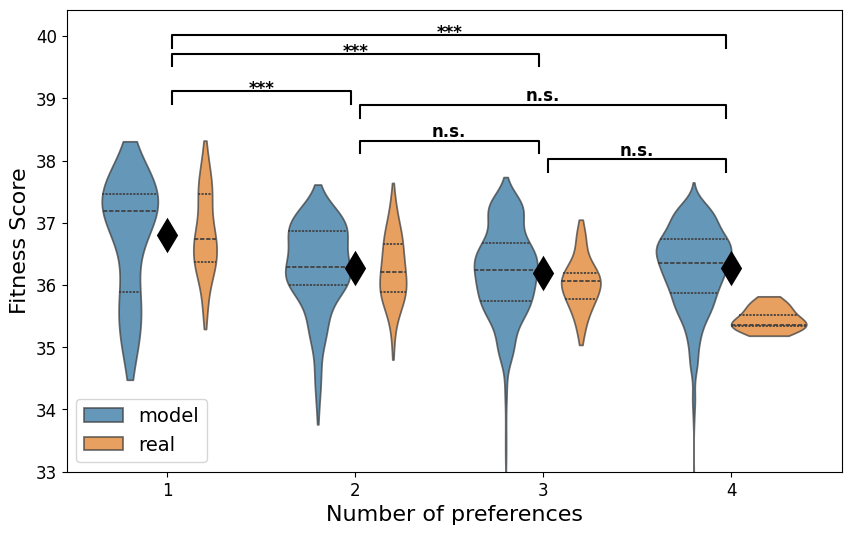

In [128]:

ANNOTATION_INCREMENT = 0.3
plt.figure(figsize=(10, 6))

sns.violinplot(data=fitness_by_prefs_df, x='n_prefs', y='fitness', palette='tab10', hue='source', inner='quart', alpha=0.75, cut=1)
# sns.swarmplot(data=fitness_by_prefs_df,  x='n_prefs', y='fitness', color='white', dodge=False, size=10, alpha=0.25)
sns.pointplot(data=fitness_by_prefs_df,  x='n_prefs', y='fitness', errorbar=('ci', 95), linestyle='none', color='black', markers='d', markersize=15)

ax = plt.gca()

pairs = [(1, 4), (1, 3), (2, 4), (1, 2), (2, 3), (3, 4)]

for i, (low, high) in enumerate(pairs[::-1]):
    annotate_significance(ax, (low, high), fitness_by_prefs_df, y_increment=i * ANNOTATION_INCREMENT + 0.1)


plt.xlabel('Number of preferences', fontsize=16)
plt.ylabel('Fitness Score', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)


plt.legend(fontsize=14)
plt.ylim(33, plt.ylim()[1])
save_plot('fitness_by_n_prefs.png')
plt.show()

In [10]:
args = Namespace(
    no_binarize=False, 
    no_merge=False, 
    use_specific_objects_ngram_model=False,
    include_predicate_under_modal_terms=False,
    include_arg_types_terms=False,
    include_compositionality_terms=False,
)
# featurizer = build_fitness_featurizer(args)

preprocessors = []

# if not args.no_binarize:
#     preprocessors.append(BinarizeFitnessFeatures())

# if not args.no_merge and args.include_arg_types_terms:  # the merge is only used for the arg_types featuers
#     preprocessors.append(MergeFitnessFeatures(COMMON_SENSE_PREDICATES_FUNCTIONS))

featurizer = ASTFitnessFeaturizer(args, preprocessors=preprocessors)

for section in ast_parser.SECTION_KEYS:
    counter = SectionNodeCount(section)
    featurizer.register(counter, section_rule=True)



In [195]:
real_game_keys = list(human_game_texts.keys())
index = 14 # 7, 12, 14

key = real_game_keys[index]
real_index = key_to_real_game_index[literal_eval(key)][0]
print(key, real_index, f'{real_game_fitness_scores[real_index]:.3f}')
print('\n' + '=' * 100 + '\n')
print(human_game_texts[key])
print('\n' + '=' * 100 + '\n')
print(ast_printer.ast_to_string(game_asts[real_index], '\n'))
print('\n' + '=' * 100 + '\n')
print(model.fitness_values[literal_eval(key)])
print('\n' + '=' * 100 + '\n')
print(human_cell_archive_game_texts[key])
print('\n' + '=' * 100 + '\n')
print(ast_printer.ast_to_string(model.population[literal_eval(key)], '\n'))

(1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0) 40 36.152


Setup: Place a green golf ball near the door and ensure it remains there for the entire game. During the game, place at least one dodgeball near the green golf ball.

Gameplay: While standing next to the green golf ball and the door, throw dodgeballs with the goal of getting them to stop inside a hexagonal bin.

Terminal: The game ends when you have thrown the same dodgeball and it has stopped moving more than once, or when you have thrown and stopped at least three different objects.

Scoring: You earn 10 points for each different object that you successfully throw into the hexagonal bin.


(define (game 60ddfb3db6a71ad9ba75e387-49) (:domain many-objects-room-v1)
(:setup
  (exists (?g - golfball_green)
    (and
      (game-conserved
        (near door ?g)
     )
      (forall (?d - dodgeball)
        (game-optional
          (near ?d ?g)
       )
     )
   )
 )
)
(:constraints
  (and
    (forall (?d - dodgeball)
      (and
        (pref

In [96]:
human_game_texts[str(real_game_index_to_key[83])]

'Setup: place a hexagonal bin on the desk next to a wall and make sure it stays there throughout the game.\n\nGameplay: stand on the rug and throw dodgeballs or blocks into the hexagonal bin.\n\nScoring: you get 1 point for each dodgeball and 2 points for each block that ends up in the hexagonal bin by the end of the game.'

{'(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)': 'Setup: place a hexagonal bin near a triangular ramp and make sure they stay in place throughout the game.\n\nGameplay: hold a ball and throw it so that it touches the triangular ramp and then lands inside the hexagonal bin.\n\nTerminal: the game ends when the hexagonal bin, which must start standing upright, is no longer upright without being touched or held by you.\n\nScoring: you earn 1 point for each time you successfully throw a ball that touches the ramp and lands in the bin.',
 '(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)': 'Setup: Place a hexagonal bin next to the bed and ensure it stays there. Make sure no teddy bears or pillows are on the bed during the game.\n\nGameplay: Stand next to a desk and throw balls aiming to get them inside the hexagonal bin.\n\nScoring: You earn 10 points for each dodgeball, 20 points for each basketball, and 30 points for each beachball that lands inside the hexagonal bin. However, you lose 1 point for each ball t

In [15]:
def _count_nodes(ast):
    return sum(v for k, v in featurizer.parse(ast, return_row=True).items() if k.startswith('node_count'))  # type: ignore

node_count_rows = []


for i, game_idx in enumerate(REAL_GAME_INDICES_TO_INCLUDE):
    key = REAL_GAME_KEY_LIST[i]
    ast = game_asts[game_idx]
    total_node_count = _count_nodes(ast)
    node_count_rows.append(['real', key, total_node_count])

for key in human_cell_archive_game_texts.keys():
    key = literal_eval(key)
    ast = model.population[key]
    total_node_count = _count_nodes(ast)
    node_count_rows.append(['matched', key, total_node_count])


for key in novel_archive_cell_game_texts.keys():
    key = literal_eval(key)
    ast = model.population[key]
    total_node_count = _count_nodes(ast)
    node_count_rows.append(['unmatched', key, total_node_count])


def full_game_id_to_str(series: pd.Series) -> str:
    return f"{series.game_id}-{series.game_type}"


node_count_df = pd.DataFrame(node_count_rows, columns=['game_type', 'game_id', 'node_count'])
node_count_df = node_count_df.assign(full_game_id=node_count_df.apply(full_game_id_to_str, axis=1))
node_count_df.to_csv('./human_evals_data/node_counts.csv', index=False)
print(node_count_df.shape)
node_count_df.head()



(100, 4)


,game_type,game_id,node_count,full_game_id
0,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)",131,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0)-real"
1,real,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",200,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)-real"
2,real,"(1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0)",222,"(1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0)-real"
3,real,"(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)",98,"(1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0)-real"
4,real,"(1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0)",107,"(1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0)-real"


In [165]:
novel_keys = list(novel_archive_cell_game_texts.keys())
for i, k in enumerate(novel_keys):
    if k not in unmatched_game_key_to_scores_without_bottom_10:
        print(i, k)

0 (1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0)
2 (1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0)
8 (1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1)
16 (1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0)
17 (1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1)
23 (1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0)
27 (1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2)
29 (1, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0)
31 (1, 1, 4, 0, 0, 0, 3, 0, 0, 0, 1, 0)
34 (1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 3)


In [172]:
novel_keys = list(novel_archive_cell_game_texts.keys())
index = 23
key = novel_keys[index]

print(key, model.fitness_values[literal_eval(key)])
print(novel_archive_cell_game_texts[key])
print('\n\n' + '=' * 100 + '\n\n')
print(ast_printer.ast_to_string(model.population[literal_eval(key)], '\n'))

(1, 1, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0) 35.68257522583008
Gameplay: move chairs around by picking them up and letting them go so they end up on desks and are moving without you holding them.

Terminal: the game ends when your score is 10 or more.

Scoring: you get 1 point each time you let go of a chair and it stops moving, and you get 4 points for each chair that is on a desk and moving without you holding it at the end of the game.




(define (game evo-8085-134-1) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - chair ?v1 - desk)
        (at-end
          (and
            (on ?v1 ?v0)
         )
       )
     )
   )
    (preference preference1
      (exists (?v2 - chair ?v1 - desktop)
        (at-end
          (and
            (on ?v1 ?v2)
            (not
              (agent_holds ?v2)
           )
            (in_motion ?v2)
         )
       )
     )
   )
    (preference preference2
      (exists (?v0 - chair)
        (then
      

In [64]:
for i, (k, v) in enumerate(novel_archive_cell_game_texts.items()):
    if 'cube' in v:
        print(i, k)

1 (1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)
5 (1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0)
7 (1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)
10 (1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0)
11 (1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)
17 (1, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1)
18 (1, 1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0)
22 (1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)
29 (1, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0)
30 (1, 0, 4, 0, 1, 1, 0, 1, 0, 1, 0, 0)
32 (1, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0, 0)
35 (1, 1, 4, 0, 0, 1, 1, 1, 0, 1, 0, 0)
37 (1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)


In [79]:
print(human_game_texts['(1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0)'])

Setup: place a hexagonal bin on the desk next to a wall and make sure it stays there throughout the game.

Gameplay: stand on the rug and throw dodgeballs or blocks into the hexagonal bin.

Scoring: you get 1 point for each dodgeball and 2 points for each block that ends up in the hexagonal bin by the end of the game.


In [187]:
for k, v in novel_archive_cell_game_texts.items():
    if all(s in v for s in ['Stack blocks in specific configurations',]): 
        print(k)

(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)
(1, 1, 3, 1, 0, 0, 0, 0, 0, 2, 0, 0)


In [188]:
key = '(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0)'

print(key, model.fitness_values[literal_eval(key)])
print(novel_archive_cell_game_texts[key])
print('\n\n' + '=' * 100 + '\n\n')
print(ast_printer.ast_to_string(model.population[literal_eval(key)], '\n'))

(1, 1, 3, 0, 0, 0, 0, 0, 0, 3, 0, 0) 35.8728141784668
Gameplay: Stack blocks in specific configurations

Scoring: You get 1 point for each stack where one cube block is on top of another cube block with a tall rectangular block on the same cube block. You also get 1 point for each stack where a cube block is on top of a tall rectangular block, which is on top of another cube block, with an additional cube block on top of the tall rectangular block, provided the bottom cube block is the same type as the tall rectangular block. Additionally, you get 1 point for each stack where a tall rectangular block is on top of a cube block, which is on top of another cube block, and the top cube block is the same type as a third cube block. Your final score is the sum of points from these three configurations.




(define (game evo-8127-244-0) (:domain many-objects-room-v1)
(:constraints
  (and
    (preference preference0
      (exists (?v0 - cube_block ?v1 - cube_block ?v2 - tall_rectangular_block 

In [27]:
s = """above,adjacent,adjacent_side,agent_crouches,agent_holds,
                     between,broken,equal_x_position,equal_z_position,
                     faces,game_over,game_start,in,in_motion,is_setup_object,
                     object_orientation,on,open,opposite,rug_color_under,same_color,
                     same_object,same_type,toggled_on,touch,
                     park,park_in,falls_over,thrown_into,thrown_onto,next_to,thrown,lands_in,lands_on"""

'|'.join([p.strip() for p in s.split(',')])

'above|adjacent|adjacent_side|agent_crouches|agent_holds|between|broken|equal_x_position|equal_z_position|faces|game_over|game_start|in|in_motion|is_setup_object|object_orientation|on|open|opposite|rug_color_under|same_color|same_object|same_type|toggled_on|touch|park|park_in|falls_over|thrown_into|thrown_onto|next_to|thrown|lands_in|lands_on'